In [44]:

import sys
import os
import os.path as osp
import argparse
import numpy as np
import cv2
import json
import torch
from glob import glob
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.nn.parallel.data_parallel import DataParallel
import torch.backends.cudnn as cudnn

sys.path.insert(0, osp.join('..', 'main'))
sys.path.insert(0, osp.join('..', 'data'))
sys.path.insert(0, osp.join('..', 'common'))
from config import cfg
cfg.trainset_3d = []
cfg.trainset_2d = ["MSCOCO_orig"]

from model_new_coral import get_model
import base
from utils.preprocessing import load_img, process_bbox, generate_patch_image, get_iou
from utils.vis import vis_keypoints_with_skeleton, save_obj, render_mesh_orthogonal
from utils.mano import mano

In [45]:
from base import Trainer
from train_coral import CoralTrainer

In [46]:
import argparse
args = argparse.Namespace(
    gpu_ids='0',
    device='cuda',
    continue_train=False,
    source_ckpt=r"C:\Users\vladi\RP\InterWild\demo\snapshot_6.pth",
    max_batches=10,
    batch_size=8,  # Small batch size for testing
    amp=True,
    grad_accumulation_steps=1
)
cfg.set_args("0", False)
cfg.train_batch_size = args.batch_size
cfg.num_thread = 1

>>> Using GPU: 0


In [47]:
trainer = Trainer()

In [48]:
trainer_coral = CoralTrainer(args)

In [49]:
cfg.trainset_2d

['MSCOCO_orig']

In [52]:
cfg.trainset_2d = ["MSCOCO"]
trainer._make_batch_generator()

01-03 02:48:48 Creating dataset...
01-03 02:48:48 Creating dataset...
01-03 02:48:48 Creating dataset...
01-03 02:48:48 Creating dataset...
01-03 02:48:48 Creating dataset...
INFO:train_logs.txt:Creating dataset...


Loading COCO train annotations...
loading annotations into memory...
Done (t=36.52s)
creating index...
index created!
Loading MANO parameters for train ...
Loaded MANO params from ..\data\MSCOCO\annotations\MSCOCO_train_MANO_NeuralAnnot.json
Processing train annotations...


100%|██████████| 262465/262465 [00:05<00:00, 44339.08it/s]


In [53]:
for b in trainer.batch_generator:
    print(b)
    break

[{'img': tensor([[[[0.5213, 0.5218, 0.5182,  ..., 0.5483, 0.4379, 0.2707],
          [0.5217, 0.5258, 0.5188,  ..., 0.5432, 0.4087, 0.2095],
          [0.5078, 0.5212, 0.5120,  ..., 0.5499, 0.4679, 0.3221],
          ...,
          [0.3626, 0.3378, 0.3222,  ..., 0.0000, 0.0000, 0.0000],
          [0.3380, 0.3271, 0.3252,  ..., 0.0000, 0.0000, 0.0000],
          [0.3187, 0.3266, 0.3302,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2884, 0.2888, 0.2864,  ..., 0.4660, 0.3601, 0.2179],
          [0.2889, 0.2925, 0.2883,  ..., 0.4596, 0.3362, 0.1596],
          [0.2755, 0.2871, 0.2831,  ..., 0.4761, 0.3939, 0.2679],
          ...,
          [0.2046, 0.1870, 0.1781,  ..., 0.0000, 0.0000, 0.0000],
          [0.1806, 0.1731, 0.1773,  ..., 0.0000, 0.0000, 0.0000],
          [0.1631, 0.1722, 0.1780,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0816, 0.0841, 0.0821,  ..., 0.4089, 0.3591, 0.2233],
          [0.0858, 0.0911, 0.0891,  ..., 0.4002, 0.3157, 0.1672],
          [0.0769, 0.0912, 0.0894

In [54]:
inputs, targets, meta_info = b

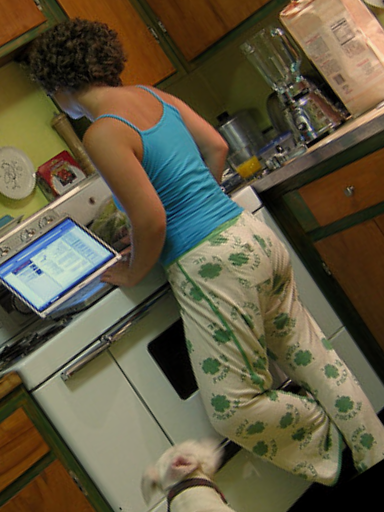

In [55]:
from torchvision import transforms
from PIL import Image
img_tensor = inputs['img'][0]
img_pil = transforms.ToPILImage()(img_tensor)
img_pil

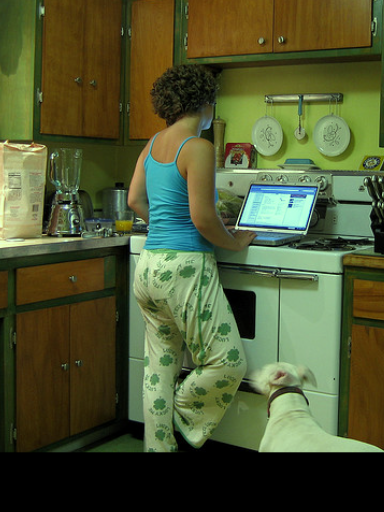

In [13]:
from torchvision import transforms
from PIL import Image
img_tensor = inputs['img'][0]
img_pil = transforms.ToPILImage()(img_tensor)
img_pil

In [66]:
targets.keys()

dict_keys(['joint_img', 'mano_joint_img', 'joint_cam', 'mano_mesh_cam', 'rel_trans', 'mano_pose', 'mano_shape', 'lhand_bbox_center', 'lhand_bbox_size', 'rhand_bbox_center', 'rhand_bbox_size'])

In [65]:
targets['joint_img'][0]

tensor([[ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 30.3562, -39.0041,   4.0000],
        [ 16.4165,  33.7751,   4.0000],
        [ 16.3229,  33.3585,   4.0000],
        [ 16.2292,  32.9419,   4.0000],
        [ 16.1238,  32.2701,   4.0000],


In [64]:
source_targets['joint_img'][0]

tensor([[ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 32.6673, -12.6730,   4.0000],
        [ 19.0687,  32.6326,   4.0000],
        [ 19.0364,  32.3619,   4.0000],
        [ 19.0041,  32.0913,   4.0000],
        [ 18.9810,  31.6578,   4.0000],


In [62]:
print(targets["lhand_bbox_center"], source_targets["lhand_bbox_center"])


tensor([[15.1173, 34.5466],
        [26.1237, 37.5896],
        [17.8987, 30.4360],
        [19.9947, 44.7739],
        [17.5396, 34.8741],
        [20.0021, 32.7895],
        [11.2775, 41.6193],
        [17.3192, 36.5737]]) tensor([[18.1934, 33.0377],
        [27.3805, 27.5484],
        [17.4867, 31.2671],
        [ 0.5000,  0.5000],
        [41.0954, 43.0602],
        [19.0125, 32.9849],
        [14.8539, 42.4097],
        [16.5568, 29.2801]])


In [29]:
source_targets['lhand_bbox_center']

tensor([[17.4315, 29.9630],
        [30.0432, 28.7804],
        [14.5661, 31.4677],
        [ 0.5000,  0.5000],
        [37.1875, 61.8727],
        [20.9594, 35.5194],
        [11.6788, 36.2520],
        [18.3324, 37.5387]])

In [57]:
trainer_coral._make_batch_generator()

01-03 02:50:49 Creating dataset for source & target in a single batch generator...
01-03 02:50:49 Creating dataset for source & target in a single batch generator...
01-03 02:50:49 Creating dataset for source & target in a single batch generator...
01-03 02:50:49 Creating dataset for source & target in a single batch generator...
01-03 02:50:49 Creating dataset for source & target in a single batch generator...
INFO:train_logs.txt:Creating dataset for source & target in a single batch generator...


loading annotations into memory...
Done (t=29.45s)
creating index...
index created!


In [58]:
for b in trainer_coral.batch_generator:
    print(b)
    break

[{'img': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4195, 0.4198, 0.4208,  ..., 0.0000, 0.0000, 0.0000],
          [0.4234, 0.4210, 0.4208,  ..., 0.0000, 0.0000, 0.0000],
          [0.4227, 0.4208, 0.4208,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4720, 0.4692, 0.4686,  ..., 0.0000, 0.0000, 0.0000],
          [0.4712, 0.4688, 0.4686,  ..., 0.0000, 0.0000, 0.0000],
          [0.4705, 0.4686, 0.4686,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000

In [59]:
source_inputs, source_targets, source_meta_info, target_inputs, target_meta_info = b

In [51]:
source_targets.keys() 

dict_keys(['joint_img', 'mano_joint_img', 'joint_cam', 'mano_mesh_cam', 'rel_trans', 'mano_pose', 'mano_shape', 'lhand_bbox_center', 'lhand_bbox_size', 'rhand_bbox_center', 'rhand_bbox_size'])

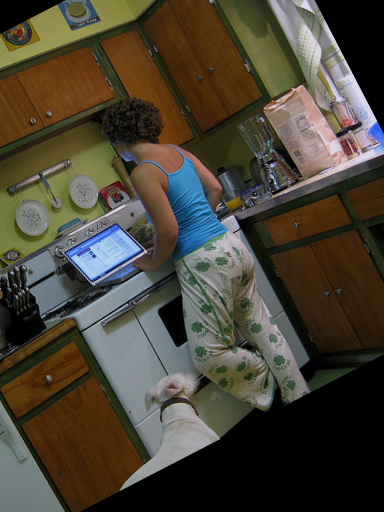

In [60]:
# Convert tensor to PIL image
img_tensor = source_inputs['img'][0]
img_pil = transforms.ToPILImage()(img_tensor)
img_pil

In [19]:
source_inputs['img'][0].shape

torch.Size([3, 512, 384])

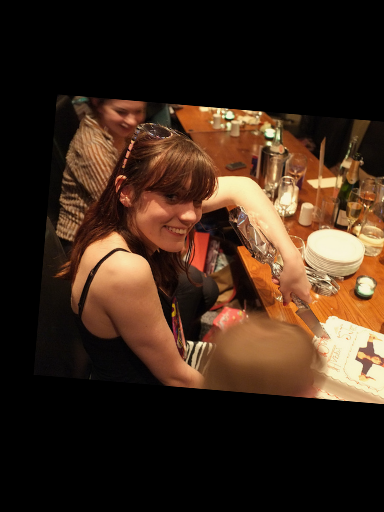

In [49]:
# Convert tensor to PIL image
img_tensor = inputs['img'][0]
img_pil = transforms.ToPILImage()(img_tensor)
img_pil

In [23]:
print(inputs.keys(), source_inputs.keys(), target_inputs.keys())

dict_keys(['img']) dict_keys(['img']) dict_keys(['img'])


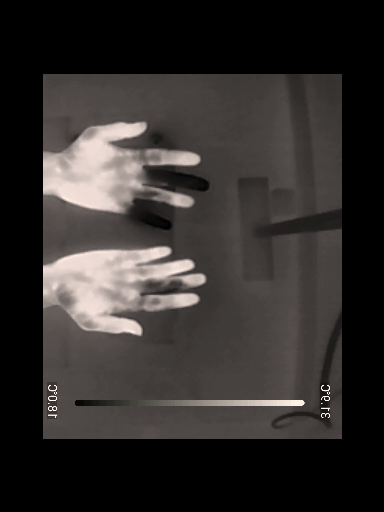

In [48]:
# Convert tensor to PIL image
img_tensor = target_inputs['img'][0]
img_pil = transforms.ToPILImage()(img_tensor)
img_pil

In [30]:
target_inputs['img'][0].shape

torch.Size([3, 512, 384])

In [32]:
print(source_meta_info.keys(), "\n", meta_info.keys())


dict_keys(['bb2img_trans', 'joint_valid', 'joint_trunc', 'mano_joint_trunc', 'mano_mesh_valid', 'rel_trans_valid', 'mano_pose_valid', 'mano_shape_valid', 'lhand_bbox_valid', 'rhand_bbox_valid', 'is_3D']) 
 dict_keys(['bb2img_trans', 'joint_valid', 'joint_trunc', 'mano_joint_trunc', 'mano_mesh_valid', 'rel_trans_valid', 'mano_pose_valid', 'mano_shape_valid', 'lhand_bbox_valid', 'rhand_bbox_valid', 'is_3D'])


In [35]:
def revert_db_data(joint_img, do_flip, img_shape, flip_pairs, img2bb_trans, rot):
    """
    Revert the main 2D transformations from transform_db_data to obtain
    original image-space keypoint coordinates.
    
    Parameters
    ----------
    joint_img : np.ndarray
        The Nx3 array of transformed keypoints (x, y, z),
        as produced by transform_db_data. 
        Here we mainly focus on reverting the 2D part.
    do_flip : bool
        Whether a left-right flip was applied during the forward transform.
    img_shape : tuple or list
        Original image shape, (height, width).
    flip_pairs : list of tuple
        Pairs of joint indices that were swapped in the forward flip.
    img2bb_trans : np.ndarray
        The 3x3 affine matrix used to transform from the original 
        image space to bounding-box-normalized space. We will invert this.
    rot : float
        The rotation in degrees that was applied in the forward direction.
        If you also want to revert the 3D rotation of cam coords, you
        would similarly invert it on the 3D data.

    Returns
    -------
    reverted_img : np.ndarray
        Nx3 array of joint positions with x,y in the original image,
        z left in the same normalized scale (unless you also undo that),
        i.e. you get back the (x,y) in original pixel coordinates.
    
    Note
    ----
    1. This function shows how to revert flipping and basic 2D steps
       (affine transform, scaling). If you need to fully revert the 3D
       rotation or depth normalization, you must also invert those steps.
    2. You must know the same 'do_flip', 'flip_pairs', 'rot', etc. used
       during the forward transform in order to reconstruct the correct 
       original image coordinates.
    """
    import numpy as np
    from config import cfg

    # ---------------------------------
    # 1) Undo the scaling from output_body_hm_shape back to the bb2img space
    #    (the forward transform did: joint_img[:,0] = (x / input_img_w) * hm_w, etc.)
    # ---------------------------------

    reverted_img = joint_img.copy()

    # 1a) Undo the scale: [0..hm_w] -> [0..input_img_w], [0..hm_h] -> [0..input_img_h]
    reverted_img[:, 0] = reverted_img[:, 0] / cfg.output_body_hm_shape[2] * cfg.input_img_shape[1]
    reverted_img[:, 1] = reverted_img[:, 1] / cfg.output_body_hm_shape[1] * cfg.input_img_shape[0]

    # 1b) Convert homogeneous for the inverse affine
    ones = np.ones_like(reverted_img[:, :1])
    xy1 = np.concatenate((reverted_img[:, :2], ones), axis=1)

    # ---------------------------------
    # 2) Undo the affine transformation using the inverse matrix
    # ---------------------------------
    inv_trans = np.linalg.inv(img2bb_trans)
    xy_orig = np.dot(inv_trans, xy1.transpose(1, 0)).transpose(1, 0)
    reverted_img[:, 0] = xy_orig[:, 0]
    reverted_img[:, 1] = xy_orig[:, 1]

    # ---------------------------------
    # 3) Undo the 2D rotation about the Z-axis (if any).
    #    This is the opposite rotation from transform_db_data.
    #    If transform_db_data used 'rot_aug_mat' around the origin,
    #    you need to replicate that exact pivot reference here and invert it.
    #    Below is a naive version if the pivot were (0,0).
    # ---------------------------------
    if rot != 0:
        # Convert degrees to radians and invert sign
        rtheta = -np.deg2rad(-rot)  # Because forward used -(rot).  We invert that.
        cos_, sin_ = np.cos(rtheta), np.sin(rtheta)

        # Simple rotation about (0,0). If your original code used the bounding-box center
        # or image center, you must also shift to that pivot, rotate, then shift back.
        R_inv = np.array([[cos_, -sin_],
                          [sin_,  cos_]], dtype=np.float32)

        # For a more accurate revert, replicate exactly how forward rotation was done:
        # pivot = (img_shape[1]/2, img_shape[0]/2) # e.g. image center
        # shift to pivot -> rotate -> shift back
        # Example below does rotation about (0,0) for demonstration only:
        xy = reverted_img[:, :2].copy().T
        reverted_img[:, :2] = np.dot(R_inv, xy).T

    # ---------------------------------
    # 4) Undo horizontal flip if do_flip was used
    #    (the forward transform did: x -> width-1 - x, and swapped flip_pairs)
    # ---------------------------------
    if do_flip:
        # invert X-flip: x -> width-1 - x
        reverted_img[:, 0] = img_shape[1] - 1 - reverted_img[:, 0]

        # swap back the flipped pairs
        for pair in flip_pairs:
            # Swap these two indices
            idx1, idx2 = pair[0], pair[1]
            temp = reverted_img[idx1, :].copy()
            reverted_img[idx1, :] = reverted_img[idx2, :]
            reverted_img[idx2, :] = temp

    #
    # If you also want to revert the z normalization:
    #    forward transform used something like:
    #        joint_img[:,2] = (joint_img[:,2] / (cfg.bbox_3d_size / 2) + 1)/2. * cfg.output_body_hm_shape[0]
    #    so you can invert that if you need actual z in mm, or the unshifted z.
    #

    return reverted_img

dict_keys(['joint_img', 'mano_joint_img', 'joint_cam', 'mano_mesh_cam', 'rel_trans', 'mano_pose', 'mano_shape', 'lhand_bbox_center', 'lhand_bbox_size', 'rhand_bbox_center', 'rhand_bbox_size']) 
 dict_keys(['joint_img', 'mano_joint_img', 'joint_cam', 'mano_mesh_cam', 'rel_trans', 'mano_pose', 'mano_shape', 'lhand_bbox_center', 'lhand_bbox_size', 'rhand_bbox_center', 'rhand_bbox_size'])


In [25]:
cnv_source_joint_img = convert_joint_img_to_orig_space(source_targets['joint_img'][0], source_meta_info['bb2img_trans'][0])

In [32]:
cnv_source_joint_img['left'] 

array([[ 401.20865,  909.4933 ],
       [ 434.061  ,  995.3269 ],
       [ 466.91327, 1081.1603 ],
       [ 450.27057, 1055.3021 ],
       [ 431.09067, 1056.146  ],
       [ 471.62912, 1090.6506 ],
       [ 475.33   , 1110.8215 ],
       [ 476.30292, 1124.2302 ],
       [ 473.30023, 1132.1831 ],
       [ 451.2855 , 1044.6215 ],
       [ 453.7388 , 1066.0986 ],
       [ 442.78485, 1063.1394 ],
       [ 428.36273, 1049.3839 ],
       [ 436.39795, 1012.1168 ],
       [ 435.38303, 1022.7975 ],
       [ 436.35593, 1036.2063 ],
       [ 432.61307, 1040.1249 ],
       [ 413.83374,  953.985  ],
       [ 403.89468,  940.345  ],
       [ 395.94342,  929.433  ],
       [ 381.28857,  906.30286]], dtype=float32)

In [34]:
img.shape

(640, 480, 3)

In [33]:
# Load and display the original image
from PIL import Image
img_path = source_meta_info['orig_img_path'][0]
img = load_img(img_path)
display(img)


array([[[201., 208., 141.],
        [205., 211., 147.],
        [242., 247., 183.],
        ...,
        [220., 218., 161.],
        [226., 225., 168.],
        [239., 240., 183.]],

       [[191., 191., 129.],
        [209., 210., 150.],
        [255., 255., 201.],
        ...,
        [244., 237., 185.],
        [238., 230., 181.],
        [239., 233., 183.]],

       [[204., 193., 139.],
        [208., 203., 147.],
        [239., 239., 179.],
        ...,
        [231., 216., 175.],
        [223., 208., 167.],
        [239., 224., 183.]],

       ...,

       [[116., 109., 116.],
        [104., 103., 111.],
        [ 94.,  96., 108.],
        ...,
        [ 42.,  58.,  57.],
        [ 89.,  98., 105.],
        [102., 102., 114.]],

       [[129., 114., 107.],
        [133., 123., 121.],
        [137., 131., 133.],
        ...,
        [ 98., 107.,  90.],
        [ 62.,  69.,  62.],
        [ 77.,  80.,  87.]],

       [[129., 104., 107.],
        [128., 109., 115.],
        [130., 1

In [46]:
source_targets['joint_img'][0]

tensor([[  36.5172,   30.3986,    4.0000],
        [  34.1641,   30.4576,    4.0000],
        [  31.8112,   30.5167,    4.0000],
        [  30.1874,   29.9191,    4.0000],
        [  28.3947,   29.5928,    4.0000],
        [  30.8695,   28.1598,    4.0000],
        [  29.0492,   27.5150,    4.0000],
        [  27.8560,   27.0728,    4.0000],
        [  26.9950,   26.7622,    4.0000],
        [  31.2606,   26.7464,    4.0000],
        [  29.6369,   26.1488,    4.0000],
        [  28.3729,   26.0014,    4.0000],
        [  27.0245,   25.9897,    4.0000],
        [  31.9879,   25.8814,    4.0000],
        [  30.2050,   25.2977,    4.0000],
        [  28.8939,   25.3468,    4.0000],
        [  27.6712,   25.6771,    4.0000],
        [  33.4544,   25.4018,    4.0000],
        [  32.3752,   24.0513,    4.0000],
        [  31.0738,   23.8430,    4.0000],
        [  30.0949,   24.0239,    4.0000],
        [  55.1109, -204.9204,    4.0000],
        [  55.1109, -204.9204,    4.0000],
        [  

In [17]:
cnv_source_joint_img

array([[288.00095, 349.54346],
       [287.4136 , 349.20343],
       [286.8263 , 348.8634 ],
       [286.51718, 348.47186],
       [286.12564, 348.12152],
       [286.94995, 348.14212],
       [286.5996 , 347.70935],
       [286.37292, 347.42087],
       [286.20807, 347.21478],
       [287.25906, 347.8536 ],
       [286.94995, 347.46207],
       [286.66144, 347.23538],
       [286.3317 , 347.0293 ],
       [287.56818, 347.75058],
       [287.21783, 347.3384 ],
       [286.88812, 347.15295],
       [286.53778, 347.04993],
       [288.00095, 347.8536 ],
       [287.93912, 347.35904],
       [287.6506 , 347.11172],
       [287.38272, 347.0087 ],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [328.02884, 294.49734],
       [

In [17]:
cnv_joint_img = joint_img_to_img(targets['joint_img'][0], meta_info['bb2img_trans'][0])


In [61]:
meta_info.keys()

dict_keys(['bb2img_trans', 'joint_valid', 'joint_trunc', 'mano_joint_trunc', 'mano_mesh_valid', 'rel_trans_valid', 'mano_pose_valid', 'mano_shape_valid', 'lhand_bbox_valid', 'rhand_bbox_valid', 'is_3D'])

In [59]:
from utils.vis import vis_keypoints_with_skeleton
from utils.mano import mano

In [20]:
from utils.preprocessing import load_img
img = load_img(source_meta_info['orig_img_path'][0])


In [37]:
len(mano.sh_skeleton)

20

In [24]:
skl = vis_keypoints_with_skeleton(img, cnv_source_joint_img, mano.sh_skeleton, color=None)


In [35]:
cnv_source_joint_img.shape

(42, 2)

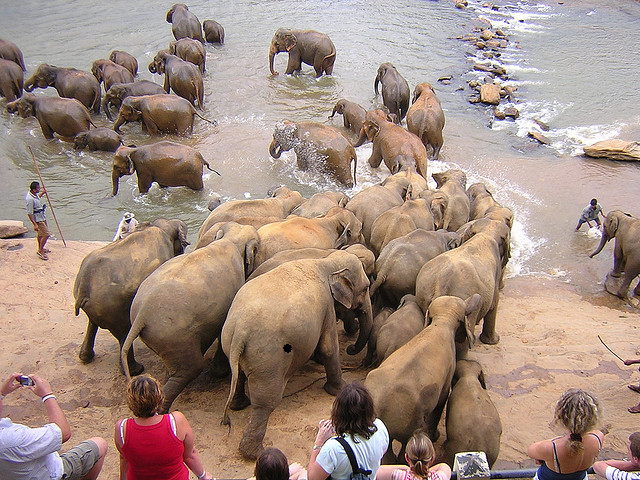

In [32]:
from PIL import Image
Image.fromarray((skl).astype('uint8'))

In [56]:
from utils.vis import vis_keypoints_with_skeleton
